In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
import torch_directml


torch.manual_seed(1)


## First

In [13]:
df = pd.read_csv("../data/testing/Locations_01_test.csv")
len(df)

10174

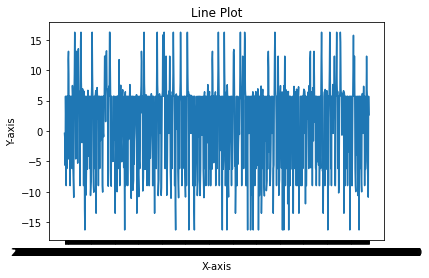

In [14]:
# x and y data
df_plot = df.loc[df["week_num"].isin([0,1,2,3])]
#df_plot = df_plot.loc[df_plot["day_new"].isin([0])]
x = df_plot["datetime"]
y = df_plot["x"]
# create a figure and axis object
fig, ax = plt.subplots()

# plot the line
ax.plot(x, y)

# set labels for x and y axis
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# set title for the plot
ax.set_title('Line Plot')

# display the plot
plt.show()


In [16]:
data = df
df.head(8125)

,day,time,time_new,day_new,week_num,datetime,x,y,z
0,0,8.015573,08:00:00,0,0.0,2023-05-01 08:00:00,-0.410000,-7.217000,-8.120000
1,0,8.017264,08:01:00,0,0.0,2023-05-01 08:01:00,-1.356797,-6.359423,-9.853136
2,0,8.034817,08:02:00,0,0.0,2023-05-01 08:02:00,-5.676789,-0.259423,-5.116555
3,0,9.362993,09:21:00,0,0.0,2023-05-01 09:21:00,5.704000,-0.259423,2.245000
4,0,9.368196,09:22:00,0,0.0,2023-05-01 09:22:00,1.430409,-0.259423,-3.693291
...,...,...,...,...,...,...,...,...,...
8120,166,17.451172,17:27:00,1,33.0,2023-10-14 17:27:00,-0.980065,-0.259423,-4.114738
8121,166,17.466667,17:28:00,1,33.0,2023-10-14 17:28:00,3.739422,-6.392756,-15.988010
8122,167,8.015494,08:00:00,2,33.0,2023-10-15 08:00:00,0.256984,-6.359423,-7.698792
8123,167,8.017187,08:01:00,2,33.0,2023-10-15 08:01:00,-0.281928,-6.359423,-8.544155


In [17]:
# extract the year, month, day, hour, minute, and second from the datetime values
data["year"] = pd.to_datetime(data["datetime"]).dt.year
data["month"] = pd.to_datetime(data["datetime"]).dt.month
data["day"] = pd.to_datetime(data["datetime"]).dt.day
data["hour"] = pd.to_datetime(data["datetime"]).dt.hour
data["minute"] = pd.to_datetime(data["datetime"]).dt.minute


# normalize the data between -1 and 1
data["x"] = (data["x"] - data["x"].mean()) / data["x"].std()

# split the data into training and validation sets
train_data = data[data["datetime"] < "2023-10-15"]
val_data = data[data["datetime"] >= "2023-10-15"]



In [18]:
# define a custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.features = data[["year", "month", "day", "hour", "minute"]].values
        self.targets = data["x"].values

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = torch.tensor(self.features[index], dtype=torch.float32)
        y = torch.tensor(self.targets[index], dtype=torch.float32)
        return x, y

# create data loaders for training and validation sets
batch_size = 32
train_dataset = TimeSeriesDataset(train_data)
val_dataset = TimeSeriesDataset(val_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size)



In [19]:
""" 
# define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)

        #print('out shape:', out.shape)
        #print('weight shape:', self.fc.weight.shape)
        out = self.fc(out[-1, :].view(1, -1))
        return out
"""    
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
        out = self.fc(out[:, -1, :])
        return out.unsqueeze(1)

    
    
    

In [ ]:
# set the hyperparameters and create the model
input_size = 5
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = LSTMModel(input_size, hidden_size, output_size).to(device)

# define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)
    
    # evaluate the model on the validation set
    val_loss = 0.0
    predictions = []
    targets = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.mean().unsqueeze(0))

            val_loss += loss.item() * batch_x.size(0)
            predictions.append(outputs.to(device).numpy())
            targets.append(batch_y.to(device).numpy())
    
    # concatenate predictions and targets arrays
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    
    # calculate evaluation metrics
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - targets))
    
    # print the results
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_dataset):.4f}, Val Loss: {val_loss/len(val_dataset):.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [125]:
import torch
torch.cuda.is_available()


True

In [126]:
import torch
print(torch.__version__) 

2.0.0+cu117


## Second

In [43]:
model = pd.read_csv("../data/testing/Locations_01_test.csv")
len(model)

10174

In [44]:
df = model[["datetime", "x"]]
timeseries = df[["x"]].values.astype('float32')
timeseries

array([[-0.40999985],
       [-1.3567972 ],
       [-5.676789  ],
       ...,
       [ 5.704     ],
       [-4.533625  ],
       [11.70756   ]], dtype=float32)

In [45]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [46]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [47]:
lookback = 100
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6716, 100, 1]) torch.Size([6716, 100, 1])
torch.Size([3258, 100, 1]) torch.Size([3258, 100, 1])


In [48]:
class XModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [50]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = XModel()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=32)

n_epochs = 5

In [56]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 6.5670, test RMSE 7.0488
Epoch 1: train RMSE 6.5247, test RMSE 7.0386
Epoch 2: train RMSE 6.4895, test RMSE 7.0301
Epoch 3: train RMSE 6.4573, test RMSE 7.0248
Epoch 4: train RMSE 6.4261, test RMSE 7.0211


In [ ]:
with torch.no_grad():

    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [64]:
model = pd.read_csv("../data/testing/Locations_01_test.csv")
len(model)

10174

In [65]:
df = model[["datetime", "x"]]
timeseries = df[["x"]].values.astype('float32')
timeseries

array([[-0.40999985],
       [-1.3567972 ],
       [-5.676789  ],
       ...,
       [ 5.704     ],
       [-4.533625  ],
       [11.70756   ]], dtype=float32)

In [66]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [54]:
df = pd.read_csv("../data/testing/Locations_01_test.csv")
df = df.loc[df["day_new"].isin([0])]
#
date_index = pd.date_range(start='2022-01-01', periods=len(df), freq='D')
df.index = date_index


test = df[["datetime","x"]]


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# split the data into training and validation sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# specify the order of the ARIMA model as (p, d, q)
# use a grid search approach to find the best values for p and q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
best_score, best_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                model = ARIMA(train['x'], order=order)
                result = model.fit()
                
                y_pred = result.forecast(steps=len(test))
                score = mean_absolute_error(test['x'], y_pred)
                #print(score)
                
                if score < best_score:
                    best_score, best_cfg = score, order
            except:
                continue

print(best_score, best_cfg)

In [ ]:
# train the model on the entire dataset using the best parameters
model = ARIMA(df['x'], order=best_cfg)
result = model.fit()

# make a forecast for the next 10 time periods
forecast = result.forecast(steps=10)

# evaluate model performance on the validation set
y_pred = result.forecast(steps=len(test))
mae = mean_absolute_error(test['x'], y_pred)
rmse = np.sqrt(mean_absolute_error(test['x'], y_pred))
mape = np.mean(np.abs((test['x'] - y_pred) / test['x'])) * 100

print("Best ARIMA order:", best_cfg)
print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

In [56]:
test.head()
df = test

In [57]:
# assuming your dataframe is called "df"
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# resample the dataframe at one-minute frequency and forward fill the previous value of x
df = df.resample('1T').ffill()

# reset the index to make datetime a column again
df.reset_index(inplace=True)

In [ ]:
df.head()

## Third

In [ ]:
df = pd.read_csv("../data/preprocessed/v2/Locations_02_prep_v2.csv", index_col = 0)
df_subset = df[200:251]

In [121]:
scaler = MinMaxScaler()
df['time'] = scaler.fit_transform(df['time'].values.reshape(-1, 1))
#df['x'] = scaler.fit_transform(df['x'].values.reshape(-1, 1))

X = df['time'].values.reshape(-1, 1)  # Reshape to (num_samples, num_features)
y = df['x'].values#.reshape(-1, 1)  # Reshape to (num_samples, 1)

sequence_length = 250  # Define the length of each sequence
X_sequences = []
y_sequences = []
for i in range(len(X) - sequence_length):
    X_sequences.append(X[i:i+sequence_length])
    y_sequences.append(y[i+sequence_length])
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)



In [122]:
train_size = int(0.8 * len(X_sequences))
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]


In [ ]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()


In [125]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [126]:
input_size = 1  # Number of features (time column)
hidden_size = 128  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 1  # Dimension of the output (predicted value y)
learning_rate = 0.001
num_epochs = 5


In [127]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)


In [128]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [129]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)

    # Compute loss
    loss = criterion(outputs, y_train)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


In [ ]:
train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_outputs = model(X_train)

    # Compute training loss
    train_loss = criterion(train_outputs, y_train)

    # Backward pass and optimize
    train_loss.backward()
    optimizer.step()

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    # Append losses to the respective lists
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


In [75]:
y_train = y_train.view(-1, 1)  # Reshape y_train to (num_samples, 1)
y_val = y_val.view(-1, 1)  # Reshape y_val to (num_samples, 1)
y_test = y_test.view(-1, 1)  # Reshape y_test to (num_samples, 1)


In [76]:
# Set the model in evaluation mode
model.eval()

with torch.no_grad():
    # Make predictions on the test set
    y_pred = model(X_test)

    # Convert arrays to PyTorch tensors
    y_test = torch.tensor(y_test).float()
    y_pred = y_pred.squeeze()  # Remove unnecessary dimensions if present

    # Calculate evaluation metrics
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

#print(f"RMSE: {rmse.item():.4f}")
print(f"MSE: {mse.item():.4f}")
print(f"MAE: {mae.item():.4f}")


MSE: 675.0528
MAE: 24.2281


C:\Users\Philipp\AppData\Local\Temp\ipykernel_6172\3754591310.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()


In [ ]:
"""
epoch 10:
RMSE: 25.4456
MSE: 647.4808
MAE: 23.6878

epoch 50:
RMSE: 16.5722
MSE: 274.6380
MAE: 14.6028

epoch 100:
RMSE: 12.4537
MSE: 155.0948
MAE: 9.9774

epoch 200:
RMSE: 10.3023
MSE: 106.1383
MAE: 7.0233

"""


## Working

In [43]:
df = pd.read_csv("../data/preprocessed/v2/Locations_00_prep_v2.csv", index_col = 0)
device = "cpu"
df = df.loc[df["day_new"].isin([1])]
df.head()
l= df["day"].unique()
len(l)

45

In [45]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

scaler = MinMaxScaler()



time = df['time'].values


X = df['time'].values.reshape(-1, 1)
y = df['x'].values.reshape(-1, 1)

sequence_length = 45

X_sequences = []
y_sequences = []
for i in range(len(X) - sequence_length):
    X_sequences.append(X[i:i+sequence_length])
    y_sequences.append(y[i+sequence_length])
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

train_size = int(0.8 * len(X_sequences))
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

X_train = torch.tensor(X_train).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
df["day"].value_counts()

In [47]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [53]:
input_size = 1  # Number of features (time column)
hidden_size = 128  # Number of LSTM units
num_layers = 4  # Number of LSTM layers
output_size = 1  # Dimension of the output (predicted value y)
learning_rate = 0.1
num_epochs = 5


In [54]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)

        # Compute loss
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [ ]:
# Set the model in evaluation mode
model.eval()

with torch.no_grad():
    # Make predictions on the test set
    y_pred = model(X_test)

    # Convert arrays to PyTorch tensors
    y_test = torch.tensor(y_test).float()
    y_pred = y_pred.squeeze()  # Remove unnecessary dimensions if present

    # Calculate evaluation metrics
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MSE: {mse.item():.4f}")
print(f"MAE: {mae.item():.4f}")